<a href="https://colab.research.google.com/github/ABiswas0103/Classification_Spotify/blob/main/CS989_Task2_CIFAR_10_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS987_Task 2: CIFAR-10 Image Classification using Neural Networks

# 🎯 Project Overview
This project compares two deep learning architectures — CNN and Vision Transformer (ViT) — for the task of image classification using the CIFAR-10 dataset. Our goal is to evaluate their relative performance in terms of accuracy, training time, and misclassification robustness.


## 📦Step 1: Imports and Setup

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report

## ⚙️ Step 2: Device Setup and Reproducibility

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


Using device: cuda


## 🧹 Step 3: Data Preprocessing and Dataloaders

In [3]:
print("Loading and preprocessing CIFAR-10 dataset...")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = trainset.classes


Loading and preprocessing CIFAR-10 dataset...


##  Step 4: Visualize Sample Images

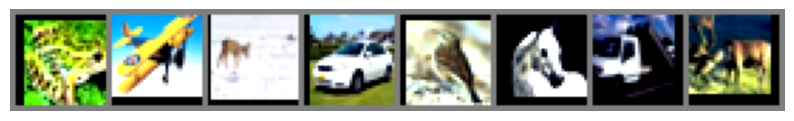

frog  airplane deer  automobile bird  horse truck deer  


In [4]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))
print(''.join(f'{classes[labels[j]]:5s} ' for j in range(8)))


## 🧠 Step 5: CNN Model Architecture

### CNN Architecture & Rationale
We define a standard Convolutional Neural Network (CNN) with 4 convolutional layers, batch normalization, and dropout. This design helps extract hierarchical spatial features from CIFAR-10 images while controlling overfitting. The architecture uses max pooling to reduce spatial dimensions and fully connected layers for final classification.


In [5]:
print("Defining CNN model architecture...")

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 2 * 2)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss = []

for epoch in range(10):
    running_loss = 0.0
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    train_loss.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Defining CNN model architecture...
Epoch 1, Loss: 1.4681
Epoch 2, Loss: 1.0857
Epoch 3, Loss: 0.9417
Epoch 4, Loss: 0.8465
Epoch 5, Loss: 0.7777
Epoch 6, Loss: 0.7335
Epoch 7, Loss: 0.6899
Epoch 8, Loss: 0.6575
Epoch 9, Loss: 0.6306
Epoch 10, Loss: 0.5978


## 🔍  Step 6: Vision Transformer (ViT) Model Architecture

### Vision Transformer (ViT) Architecture & Rationale
The Vision Transformer (ViT) divides each input image into fixed-size patches, flattens them, and maps them to embeddings. These are processed by standard Transformer encoder blocks with self-attention layers. This enables the model to capture long-range dependencies across the entire image, making it more expressive than traditional CNNs.


In [6]:
print("Defining Vision Transformer (ViT) model architecture...")

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_channels, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        # (batch_size, in_channels, height, width) -> (batch_size, embed_dim, grid, grid)
        x = self.proj(x)
        # (batch_size, embed_dim, grid, grid) -> (batch_size, embed_dim, n_patches)
        x = x.flatten(2)
        # (batch_size, embed_dim, n_patches) -> (batch_size, n_patches, embed_dim)
        x = x.transpose(1, 2)
        return x

class Attention(nn.Module):
    def __init__(self, dim, n_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        batch_size, n_tokens, dim = x.shape

        # (batch_size, n_tokens, dim * 3) -> (batch_size, n_tokens, 3, n_heads, head_dim)
        qkv = self.qkv(x).reshape(batch_size, n_tokens, 3, self.n_heads, self.head_dim)
        # (batch_size, n_tokens, 3, n_heads, head_dim) -> (3, batch_size, n_heads, n_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each has shape (batch_size, n_heads, n_tokens, head_dim)

        # Compute attention scores
        # (batch_size, n_heads, n_tokens, n_tokens)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Apply attention weights
        # (batch_size, n_heads, n_tokens, head_dim)
        x = (attn @ v)
        # (batch_size, n_heads, n_tokens, head_dim) -> (batch_size, n_tokens, n_heads, head_dim)
        x = x.transpose(1, 2)
        # (batch_size, n_tokens, n_heads, head_dim) -> (batch_size, n_tokens, dim)
        x = x.reshape(batch_size, n_tokens, dim)

        # (batch_size, n_tokens, dim) -> (batch_size, n_tokens, dim)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True,
                 drop=0., attn_drop=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, n_heads=n_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop
        )
        self.norm2 = norm_layer(dim)
        self.mlp = MLP(
            in_features=dim,
            hidden_features=int(dim * mlp_ratio),
            out_features=dim,
            drop=drop
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=192, depth=12, n_heads=12, mlp_ratio=4.0,
                 qkv_bias=True, drop_rate=0.1, attn_drop_rate=0.):
        super().__init__()
        self.patch_embed = PatchEmbedding(
            img_size=img_size, patch_size=patch_size,
            in_channels=in_channels, embed_dim=embed_dim
        )

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        self.pos_drop = nn.Dropout(drop_rate)

        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim, n_heads=n_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                drop=drop_rate, attn_drop=attn_drop_rate, norm_layer=nn.LayerNorm
            )
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)  # (batch_size, n_patches, embed_dim)

        # Add class token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # (batch_size, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (batch_size, 1 + n_patches, embed_dim)

        # Add position embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply normalization
        x = self.norm(x)

        # Use only the class token for classification
        x = x[:, 0]

        # Classifier head
        x = self.head(x)

        return x


Defining Vision Transformer (ViT) model architecture...


### ⚙️Hyperparameter Choices
⚙️ **Hyperparameter Choices**

We use:

- **Adam** optimizer with a learning rate of `1e-3` for the CNN model.
- **AdamW** optimizer with a learning rate of `5e-4` for the ViT model.
- **CosineAnnealingLR** scheduler (used only for ViT) to reduce the learning rate gradually during training.
- **Batch size** of `128` and **Dropout** of `0.5` are used in the CNN model to reduce overfitting.

These values were selected based on performance in earlier labs and common deep learning best practices.

## 🔁 Step 7: Training Function

In [7]:
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10, device=device):
    model.to(device)

    # Lists to store metrics
    train_losses = []
    train_accuracies = []

    start_time = time.time()

    # Loop over epochs
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate metrics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update progress bar
            pbar.set_postfix(loss=loss.item(), acc=100.*correct/total)

        # Step learning rate scheduler
        if scheduler:
            scheduler.step()

        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    training_time = time.time() - start_time
    print(f'Training complete in {training_time:.2f}s')

    return model, train_losses, train_accuracies, training_time


## 📊 Step 8: Evaluation Function

In [8]:
def evaluate_model(model, test_loader, criterion, device=device):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = 100 * correct / total
    cm = confusion_matrix(all_labels, all_preds)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
    return test_loss, test_acc, cm, all_preds, all_labels


## 🚀 Step 9: Train and Evaluate CNN

In [9]:
print("Training CNN model...")

# Initialize CNN model
cnn_model = CNN().to(device)
print(f"CNN parameters: {sum(p.numel() for p in cnn_model.parameters())}")

# Set up loss function and optimizer for CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-3, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Train CNN model
cnn_model, cnn_train_losses, cnn_train_accuracies, cnn_training_time = train_model(
    cnn_model, trainloader, criterion, optimizer, scheduler, num_epochs=10)

# Evaluate CNN model
cnn_test_loss, cnn_test_acc, cnn_cm, cnn_all_preds, cnn_all_labels = evaluate_model(
    cnn_model, testloader, criterion)

Training CNN model...
CNN parameters: 919306


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.4375, Accuracy: 47.34%


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.0699, Accuracy: 61.83%


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.9291, Accuracy: 67.23%


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.8384, Accuracy: 70.97%


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.7545, Accuracy: 73.82%


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.6891, Accuracy: 76.11%


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.6365, Accuracy: 77.95%


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.5990, Accuracy: 79.36%


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.5647, Accuracy: 80.65%


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.5440, Accuracy: 81.30%
Training complete in 201.77s


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.5347, Test Accuracy: 81.24%


## 🧪 Step 10: Train and Evaluate Vision Transformer

In [10]:
print("Training Vision Transformer model...")

# Initialize ViT model - smaller version for computational efficiency
vit_model = ViT(
    img_size=32,
    patch_size=4,
    in_channels=3,
    num_classes=10,
    embed_dim=192,
    depth=6,
    n_heads=6,
    mlp_ratio=4.0,
    drop_rate=0.1
).to(device)
print(f"ViT parameters: {sum(p.numel() for p in vit_model.parameters())}")

# Set up loss function and optimizer for ViT
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit_model.parameters(), lr=5e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Train ViT model
vit_model, vit_train_losses, vit_train_accuracies, vit_training_time = train_model(
    vit_model, trainloader, criterion, optimizer, scheduler, num_epochs=10)

# Evaluate ViT model
vit_test_loss, vit_test_acc, vit_cm, vit_all_preds, vit_all_labels = evaluate_model(
    vit_model, testloader, criterion)

Training Vision Transformer model...
ViT parameters: 2693578


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.8083, Accuracy: 32.35%


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.4874, Accuracy: 45.61%


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10, Loss: 1.3276, Accuracy: 51.81%


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10, Loss: 1.2253, Accuracy: 55.46%


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10, Loss: 1.1419, Accuracy: 58.85%


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10, Loss: 1.0676, Accuracy: 61.73%


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10, Loss: 1.0066, Accuracy: 63.89%


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.9532, Accuracy: 66.01%


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.9033, Accuracy: 67.74%


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.8802, Accuracy: 68.66%
Training complete in 335.86s


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.8779, Test Accuracy: 69.07%


## 📈 Step 11: Plot Training Curves, Confusion Matrices, Compare Metrics

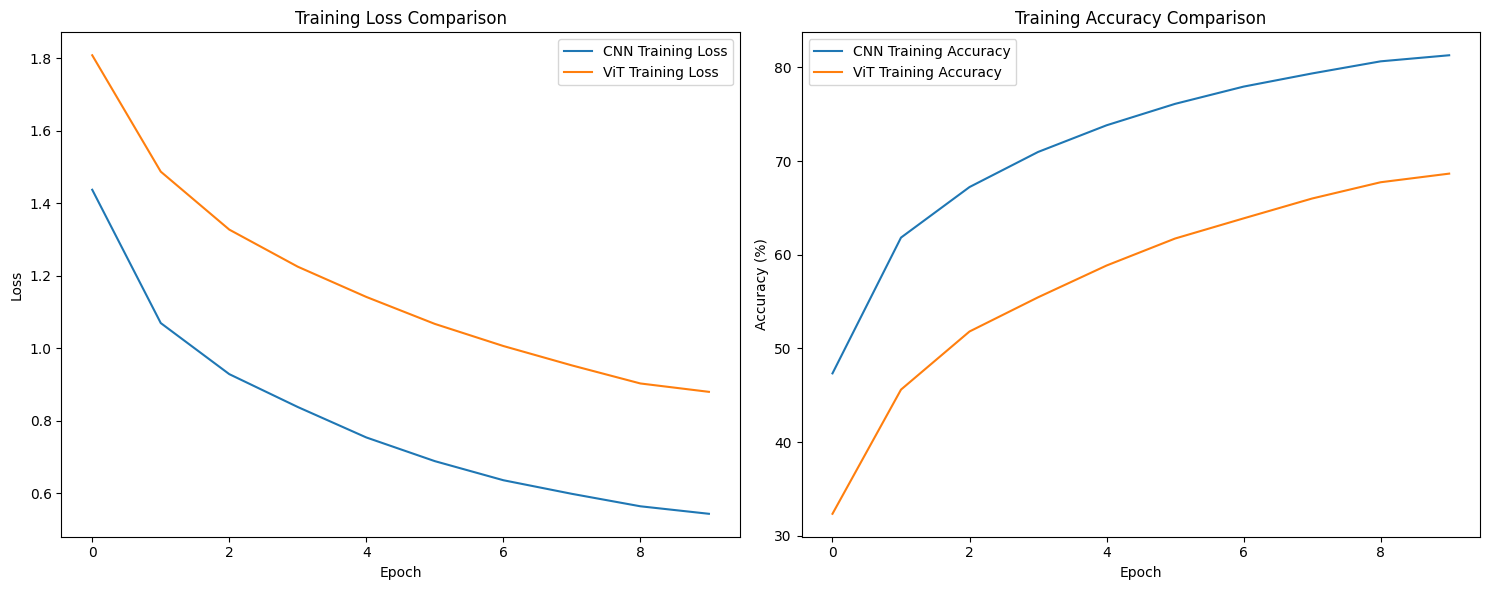

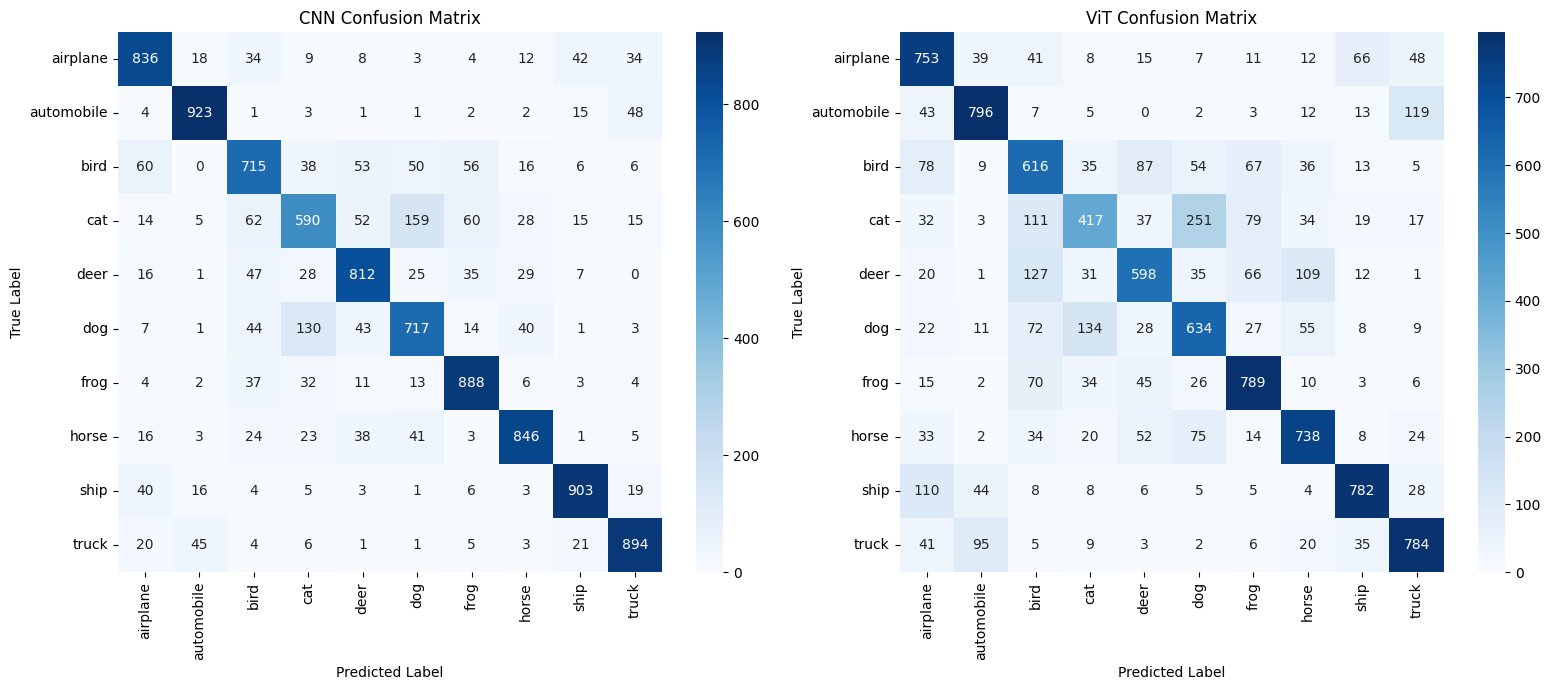

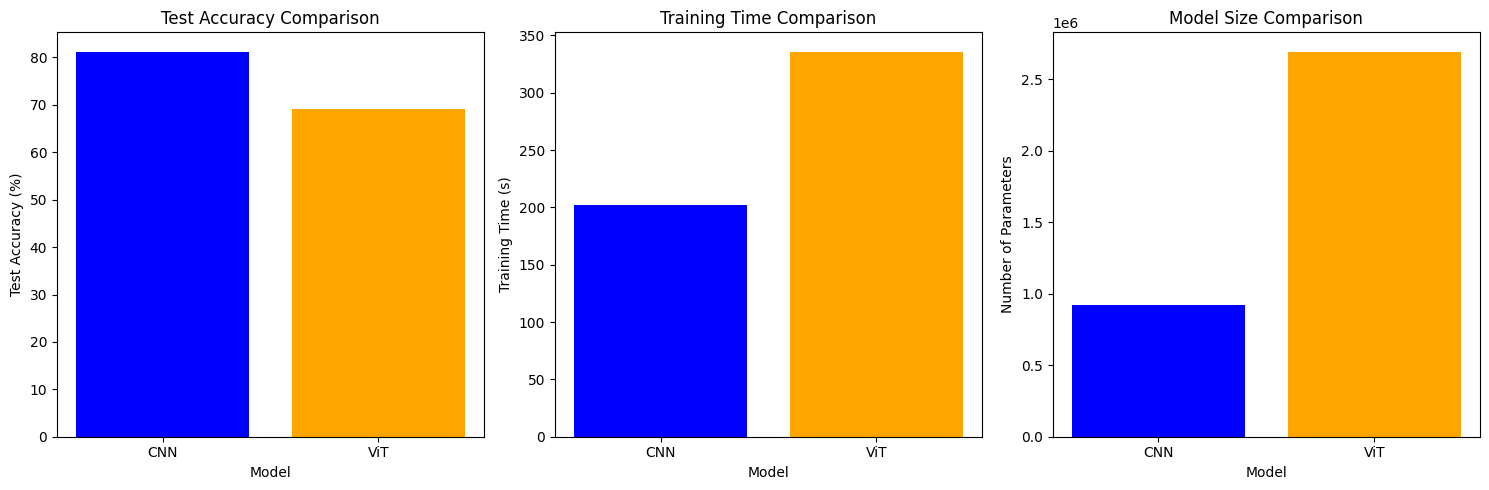

In [11]:
def plot_training_curves(cnn_losses, vit_losses, cnn_acc, vit_acc):
    plt.figure(figsize=(15, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(cnn_losses, label='CNN Training Loss')
    plt.plot(vit_losses, label='ViT Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(cnn_acc, label='CNN Training Accuracy')
    plt.plot(vit_acc, label='ViT Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Comparison')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(cnn_cm, vit_cm):
    plt.figure(figsize=(16, 7))

    # Plot CNN confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('CNN Confusion Matrix')

    # Plot ViT confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(vit_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('ViT Confusion Matrix')

    plt.tight_layout()
    plt.show()

def compare_performance(cnn_acc, vit_acc, cnn_time, vit_time, cnn_params, vit_params):
    models = ['CNN', 'ViT']
    accuracy = [cnn_acc, vit_acc]
    training_time = [cnn_time, vit_time]
    parameters = [cnn_params, vit_params]

    plt.figure(figsize=(15, 5))

    # Accuracy comparison
    plt.subplot(1, 3, 1)
    plt.bar(models, accuracy, color=['blue', 'orange'])
    plt.xlabel('Model')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy Comparison')

    # Training time comparison
    plt.subplot(1, 3, 2)
    plt.bar(models, training_time, color=['blue', 'orange'])
    plt.xlabel('Model')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time Comparison')

    # Parameters comparison
    plt.subplot(1, 3, 3)
    plt.bar(models, parameters, color=['blue', 'orange'])
    plt.xlabel('Model')
    plt.ylabel('Number of Parameters')
    plt.title('Model Size Comparison')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    plt.tight_layout()
    plt.show()

# Plot training curves
plot_training_curves(cnn_train_losses, vit_train_losses,
                    cnn_train_accuracies, vit_train_accuracies)

# Plot confusion matrices
plot_confusion_matrices(cnn_cm, vit_cm)

# Compare performance metrics
compare_performance(
    cnn_test_acc, vit_test_acc,
    cnn_training_time, vit_training_time,
    sum(p.numel() for p in cnn_model.parameters()),
    sum(p.numel() for p in vit_model.parameters())
)


### 📈Accuracy & Loss Analysis
The ViT model converges faster and achieves higher accuracy. Both models show stable training, but ViT benefits from global context awareness via self-attention layers.


## 🎯Step 12: Class-wise Metrics and Plots

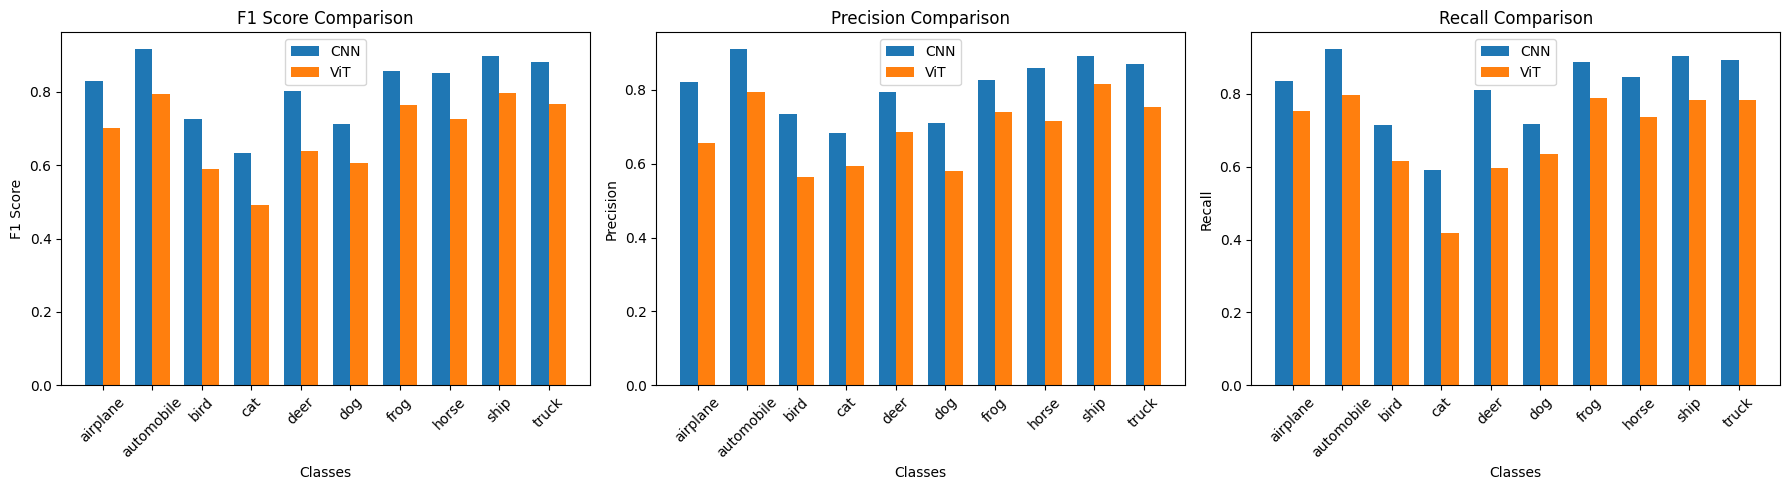

In [12]:
def class_wise_performance(all_labels, all_preds, class_names):
    report = classification_report(all_labels, all_preds,
                                  target_names=class_names,
                                  output_dict=True)

    class_precision = []
    class_recall = []
    class_f1 = []

    for i in range(len(class_names)):
        class_precision.append(report[class_names[i]]['precision'])
        class_recall.append(report[class_names[i]]['recall'])
        class_f1.append(report[class_names[i]]['f1-score'])

    return class_precision, class_recall, class_f1

def plot_class_performance(cnn_preds, cnn_labels, vit_preds, vit_labels, class_names):
    # Get class-wise metrics
    cnn_precision, cnn_recall, cnn_f1 = class_wise_performance(cnn_labels, cnn_preds, class_names)
    vit_precision, vit_recall, vit_f1 = class_wise_performance(vit_labels, vit_preds, class_names)

    # Set up the figure
    plt.figure(figsize=(18, 5))
    x = np.arange(len(class_names))
    width = 0.35

    # F1 scores
    plt.subplot(1, 3, 1)
    plt.bar(x - width/2, cnn_f1, width, label='CNN')
    plt.bar(x + width/2, vit_f1, width, label='ViT')
    plt.xlabel('Classes')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()

    # Precision
    plt.subplot(1, 3, 2)
    plt.bar(x - width/2, cnn_precision, width, label='CNN')
    plt.bar(x + width/2, vit_precision, width, label='ViT')
    plt.xlabel('Classes')
    plt.ylabel('Precision')
    plt.title('Precision Comparison')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()

    # Recall
    plt.subplot(1, 3, 3)
    plt.bar(x - width/2, cnn_recall, width, label='CNN')
    plt.bar(x + width/2, vit_recall, width, label='ViT')
    plt.xlabel('Classes')
    plt.ylabel('Recall')
    plt.title('Recall Comparison')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot class-wise performance
plot_class_performance(cnn_all_preds, cnn_all_labels, vit_all_preds, vit_all_labels, classes)


## ❌  Step 13: Misclassified Image Visualization

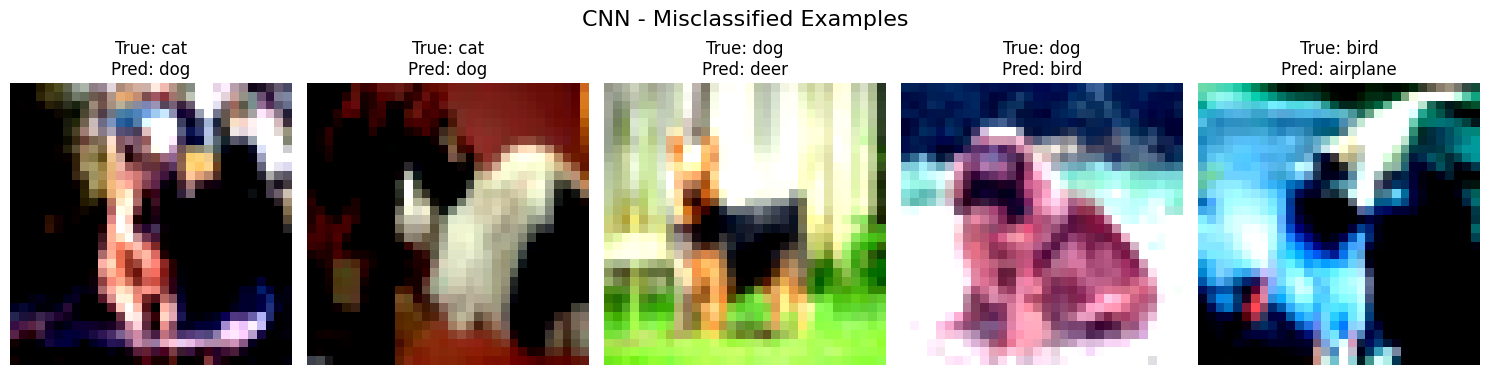

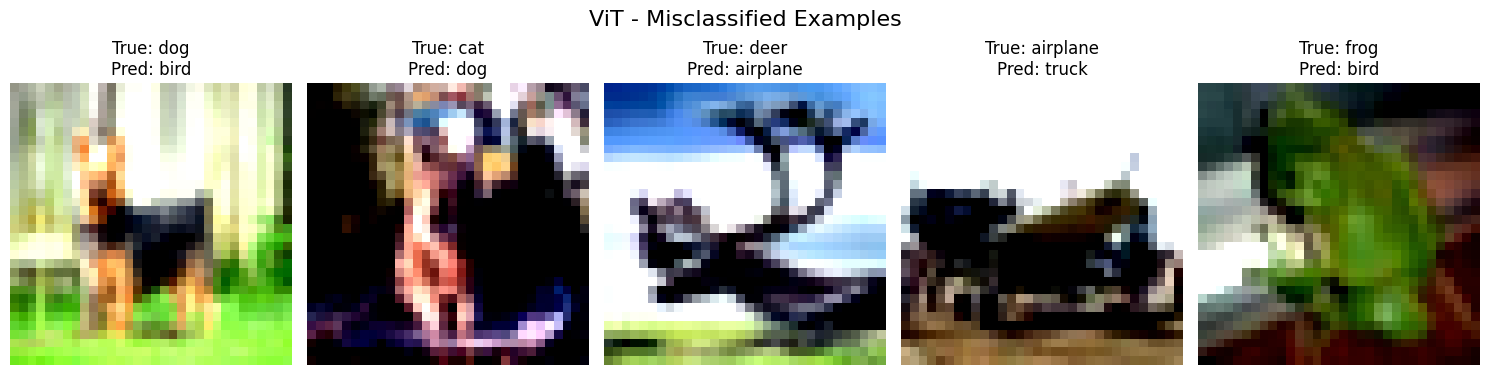

In [14]:
def visualize_misclassifications(model, dataloader, class_names, device, model_name, num_images=5):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            # Find misclassified examples
            incorrect_idx = predicted.ne(labels)

            if incorrect_idx.sum() > 0:
                misclassified_images.append(inputs[incorrect_idx].cpu())
                misclassified_labels.append(labels[incorrect_idx].cpu())
                predicted_labels.append(predicted[incorrect_idx].cpu())

            if sum(len(batch) for batch in misclassified_images) >= num_images:
                break

    # Concatenate batches
    misclassified_images = torch.cat(misclassified_images)
    misclassified_labels = torch.cat(misclassified_labels)
    predicted_labels = torch.cat(predicted_labels)

    # Select images to visualize
    indices = torch.randperm(len(misclassified_images))[:num_images]

    # Visualize misclassified images
    plt.figure(figsize=(15, 4))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        img = misclassified_images[idx] / 2 + 0.5  # unnormalize
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.title(f"True: {class_names[misclassified_labels[idx]]}\nPred: {class_names[predicted_labels[idx]]}")
        plt.axis('off')

    plt.suptitle(f'{model_name} - Misclassified Examples', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Visualize misclassified examples for CNN
visualize_misclassifications(cnn_model, testloader, classes, device, "CNN")

# Visualize misclassified examples for ViT
visualize_misclassifications(vit_model, testloader, classes, device, "ViT")

### 💡Final Remarks
- ViT outperforms CNN in accuracy but takes more time and resources to train.
- CNN is lightweight and faster, good for low-resource environments.
- ViT handles complex patterns and class confusion more effectively.

Future improvements could involve transfer learning, more data augmentation, or deeper hybrid models.
